### 1. ИМПОРТЫ

In [44]:
import os 
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau

### 2. ЗАГРУЗКА И ПЕРВИЧНАЯ ОБРАБОТКА ДАННЫХ

In [45]:
# Настройка путей к данным
PATH = "data"
pd.set_option('display.width', 1000)  # Для корректного отображения таблиц

FILETEST = os.path.join(PATH, "test.csv")    
FILETRAIN = os.path.join(PATH, "train.csv") 

# Словарь для перевода названий столбцов
column_translation = {
    'Survived': 'Выжил',
    'Pclass': 'Класс Билета',
    'Name': 'Имя',
    'Sex': 'Пол',
    'Age': 'Возраст',
    'SibSp': 'Братьев/Сестер/Супругов на борту',
    'Parch': 'Родителей/Детей на борту',
    'Ticket': 'Номер Билета',
    'Fare': 'Тариф',
    'Cabin': 'Каюта',
    'Embarked': 'Порт Посадки'
}

# Загрузка данных
try:
    df_train = pd.read_csv(FILETRAIN)
    df_test = pd.read_csv(FILETEST)
    
    # Сохраняем копию тестовых данных для создания submission
    df_test_original = df_test.copy()
    
    # Удаляем PassengerId из рабочих копий
    df_train.drop('PassengerId', axis=1, inplace=True)
    df_test.drop('PassengerId', axis=1, inplace=True)
    
    # Переименовываем столбцы
    df_train.rename(columns=column_translation, inplace=True, errors='ignore')
    df_test.rename(columns=column_translation, inplace=True, errors='ignore')
    
    print("Данные успешно загружены!")
    print(f"\nРазмер тренировочного набора: {df_train.shape}")
    print(f"Размер тестового набора: {df_test.shape}")
    print("\nПервые 5 строк тренировочного набора:")
    print(df_train.head())
    
except FileNotFoundError:
    print(f"Ошибка: Один из файлов не найден. Проверьте пути:\n- {FILETRAIN}\n- {FILETEST}")
except Exception as e:
    print(f"Произошла ошибка при загрузке данных: {e}")

# Анализ пропущенных данных
print(f"\nВсего пассажиров с пропущенным возрастом: {df_train['Возраст'].isnull().sum()}")



Данные успешно загружены!

Размер тренировочного набора: (891, 11)
Размер тестового набора: (418, 10)

Первые 5 строк тренировочного набора:
   Выжил  Класс Билета                                                Имя     Пол  Возраст  Братьев/Сестер/Супругов на борту  Родителей/Детей на борту      Номер Билета    Тариф Каюта Порт Посадки
0      0             3                            Braund, Mr. Owen Harris    male     22.0                                 1                         0         A/5 21171   7.2500   NaN            S
1      1             1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female     38.0                                 1                         0          PC 17599  71.2833   C85            C
2      1             3                             Heikkinen, Miss. Laina  female     26.0                                 0                         0  STON/O2. 3101282   7.9250   NaN            S
3      1             1       Futrelle, Mrs. Jacques Heath (Lily May Pee

### 3. ИЗВЛЕЧЕНИЕ ДОПОЛНИТЕЛЬНЫХ ПРИЗНАКОВ

In [46]:
def extract_features(df):
    """Извлекает дополнительные признаки из имени пассажира"""
    # Извлекаем фамилию (до первой запятой)
    df['Фамилия'] = df['Имя'].apply(lambda name: name.split(',')[0].strip())
    
    # Извлекаем титул (статус)
    df['Титул'] = df['Имя'].str.extract(r',\s*([A-Za-z]+)\.', expand=False)
    
    return df

# Применяем извлечение признаков
df_train = extract_features(df_train)
df_test = extract_features(df_test)

# Стандартизация титулов
def standardize_titles(df):
    """Стандартизирует редкие титулы"""
    rare_titles = ['Dr', 'Rev', 'Major', 'Col', 'Don', 'Lady', 'Sir', 'Capt', 
                   'Jonkheer', 'Dona', 'Countess']
    
    df['Титул'] = df['Титул'].replace(rare_titles, 'Rare')
    df['Титул'] = df['Титул'].replace(['Mlle', 'Ms'], 'Miss')
    df['Титул'] = df['Титул'].replace('Mme', 'Mrs')
    
    return df

df_train = standardize_titles(df_train)
df_test = standardize_titles(df_test)

print("\nУникальные титулы в тренировочном наборе:")
print(df_train['Титул'].value_counts())



Уникальные титулы в тренировочном наборе:
Титул
Mr        517
Miss      185
Mrs       126
Master     40
Rare       22
Name: count, dtype: int64


### 4. ОБРАБОТКА ПРОПУЩЕННЫХ ЗНАЧЕНИЙ

In [47]:
# Заполнение пропусков в возрасте для тестового набора
if df_test['Возраст'].isnull().any():
    age_median_train = df_train['Возраст'].median()
    df_test['Возраст'] = df_test['Возраст'].fillna(age_median_train)
    print(f"Пропуски в 'Возраст' df_test заполнены медианой: {age_median_train}")

# Заполнение пропусков в тарифе для тестового набора
if df_test['Тариф'].isnull().any():
    fare_median_train = df_train['Тариф'].median()
    df_test['Тариф'] = df_test['Тариф'].fillna(fare_median_train)
    print(f"Пропуски в 'Тариф' df_test заполнены медианой: {fare_median_train}")

# Удаление строк с пропущенными значениями из тренировочного набора
df_train.dropna(subset=['Порт Посадки', 'Титул', 'Возраст'], inplace=True)

print(f"\nРазмер тренировочного набора после очистки: {df_train.shape}")

Пропуски в 'Возраст' df_test заполнены медианой: 28.0
Пропуски в 'Тариф' df_test заполнены медианой: 14.4542

Размер тренировочного набора после очистки: (711, 13)


### 5. ОБРАБОТКА БИЛЕТОВ

In [48]:
def process_tickets(df):
    """Обрабатывает номера билетов, извлекая префикс и серию"""
    # Извлечение префикса билета
    df['Префикс Билета'] = df['Номер Билета'].apply(
        lambda name: (
            'NONE' 
            if (name.split(' ')[0].strip() == name.split(' ')[-1].strip())
            else name.split(' ')[0].strip()
        )
    )
    
    # Извлечение серии билета
    df['Серия Билета'] = df['Номер Билета'].apply(
        lambda name: name.split(' ')[-1].strip()
    )
    
    # Нормализация префиксов
    df['Префикс Билета'] = df['Префикс Билета'].str.upper()
    df['Префикс Билета'] = df['Префикс Билета'].str.replace('.', '', regex=False)
    df['Префикс Билета'] = df['Префикс Билета'].str.replace('/', '', regex=False)
    
    return df

df_train = process_tickets(df_train)
df_test = process_tickets(df_test)

# Нормализация префиксов билетов
def normalize_prefix(current_prefix_value, target_prefixes):
    """Нормализует префиксы билетов к стандартным значениям"""
    if not isinstance(current_prefix_value, str):
        return current_prefix_value 
    
    for pref_target in target_prefixes:
        if pref_target in current_prefix_value:
            return pref_target
    return current_prefix_value

list_pref = ['SOTON', 'STON', 'PARIS', 'PP', 'A4', 'A5']
df_train['Префикс Билета'] = df_train['Префикс Билета'].apply(
    lambda x: normalize_prefix(x, list_pref)
)
df_test['Префикс Билета'] = df_test['Префикс Билета'].apply(
    lambda x: normalize_prefix(x, list_pref)
)

# Обработка редких префиксов
threshold = 5
prefix_counts_train = df_train['Префикс Билета'].value_counts()
rare_prefixes_train = prefix_counts_train[prefix_counts_train < threshold].index.tolist()

df_train['Префикс Билета'] = df_train['Префикс Билета'].apply(
    lambda x: 'RARE' if x in rare_prefixes_train else x
)

frequent_prefixes_train = prefix_counts_train[prefix_counts_train >= threshold].index.tolist()
if 'NONE' not in frequent_prefixes_train and 'NONE' in df_train['Префикс Билета'].unique():
    frequent_prefixes_train.append('NONE')

df_test['Префикс Билета'] = df_test['Префикс Билета'].apply(
    lambda x: x if x in frequent_prefixes_train else 'RARE'
)

### 6. ПРЕОБРАЗОВАНИЕ ТИПОВ ДАННЫХ

In [49]:
# Преобразование пола в числовой формат
gender_mapping = {'male': 0, 'female': 1}
df_train['Пол'] = df_train['Пол'].map(gender_mapping)
df_test['Пол'] = df_test['Пол'].map(gender_mapping)

# Извлечение палубы из номера каюты
df_train['Палуба'] = df_train['Каюта'].apply(
    lambda x: str(x)[0] if pd.notnull(x) else 'U'
)
df_test['Палуба'] = df_test['Каюта'].apply(
    lambda x: str(x)[0] if pd.notnull(x) else 'U'
)

# Удаление ненужных столбцов
columns_to_drop = ['Каюта', 'Номер Билета', 'Имя']
df_train.drop(columns_to_drop, axis=1, inplace=True)
df_test.drop(columns_to_drop, axis=1, inplace=True)

# Обработка серии билета
df_train['Серия Билета'] = df_train['Серия Билета'].str.replace("LINE", '0', regex=False)
df_train['Серия Билета'] = df_train['Серия Билета'].astype(int)
df_test['Серия Билета'] = df_test['Серия Билета'].str.replace("LINE", '0', regex=False)
df_test['Серия Билета'] = df_test['Серия Билета'].astype(int)

### 7. ПОДГОТОВКА ДАННЫХ ДЛЯ ОБУЧЕНИЯ

In [50]:
# Определение целевой переменной и признаков
target = 'Выжил'
categorical_features = ['Титул', 'Палуба']

# Создание копий для обработки
df_train_processed = df_train.copy()
df_test_processed = df_test.copy()

print(f"\nРазмер до One-Hot Encoding:")
print(f"Train: {df_train_processed.shape}, Test: {df_test_processed.shape}")

# One-Hot Encoding для категориальных признаков
df_train_processed = pd.get_dummies(
    df_train_processed, 
    columns=categorical_features, 
    drop_first=True, 
    dtype=int
)
df_test_processed = pd.get_dummies(
    df_test_processed, 
    columns=categorical_features, 
    drop_first=True, 
    dtype=int
)

# Удаление дополнительных столбцов
additional_drops = ['Фамилия', 'Серия Билета', 'Префикс Билета', 'Порт Посадки']
df_train_processed.drop(additional_drops, axis=1, inplace=True, errors='ignore')
df_test_processed.drop(additional_drops, axis=1, inplace=True, errors='ignore')


# Выравнивание столбцов между train и test
train_cols = df_train_processed.drop(target, axis=1, errors='ignore').columns.tolist()
test_cols = df_test_processed.columns.tolist()

# Добавление отсутствующих столбцов в test
for col in train_cols:
    if col not in test_cols:
        df_test_processed[col] = 0

# Удаление лишних столбцов из test
for col in test_cols:
    if col not in train_cols:
        print(f"ВНИМАНИЕ: Удаляем столбец '{col}' из test набора")
        df_test_processed.drop(col, axis=1, inplace=True)

print(f"\nРазмер после обработки:")
print(f"Train: {df_train_processed.shape}, Test: {df_test_processed.shape}")

# Разделение на признаки и целевую переменную
X = df_train_processed.drop(target, axis=1)
y = df_train_processed[target]
X_test_final = df_test_processed.copy()

# Разделение на обучающую и валидационную выборки
X_train, X_val, y_train, y_val = train_test_split(
    X, y, 
    test_size=0.25, 
    random_state=42, 
    stratify=y
)

print(f"\nРазделение данных:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val: {X_val.shape}, y_val: {y_val.shape}")


Размер до One-Hot Encoding:
Train: (711, 13), Test: (418, 12)

Размер после обработки:
Train: (711, 19), Test: (418, 18)

Разделение данных:
X_train: (533, 18), y_train: (533,)
X_val: (178, 18), y_val: (178,)


### 8. ПРЕОБРАЗОВАНИЕ В PYTORCH ТЕНЗОРЫ

In [51]:
# Преобразование в тензоры PyTorch
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_final.values, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).unsqueeze(1)

print("Данные преобразованы в тензоры PyTorch")
print(f"X_train_tensor: {X_train_tensor.shape}")
print(f"y_train_tensor: {y_train_tensor.shape}")

Данные преобразованы в тензоры PyTorch
X_train_tensor: torch.Size([533, 18])
y_train_tensor: torch.Size([533, 1])


### 9. СОЗДАНИЕ DATASET И DATALOADER

In [52]:
class TitanicDataset(Dataset):
    """Класс для работы с данными Titanic"""
    
    def __init__(self, features, labels=None):
        self.features = features
        self.labels = labels
        self.is_test = labels is None
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        item_features = self.features[idx]
        if self.is_test:
            return item_features
        else:
            item_labels = self.labels[idx]
            return item_features, item_labels

# Создание datasets
train_dataset = TitanicDataset(X_train_tensor, y_train_tensor)
val_dataset = TitanicDataset(X_val_tensor, y_val_tensor)
test_dataset = TitanicDataset(X_test_tensor)

# Создание dataloaders
BATCH_SIZE = 16
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"\nDataLoader'ы созданы с размером батча: {BATCH_SIZE}")



DataLoader'ы созданы с размером батча: 16


### 10. ОПРЕДЕЛЕНИЕ МОДЕЛИ

In [53]:
class LogisticRegressionModel(nn.Module):
    """Модель логистической регрессии с батч-нормализацией"""
    
    def __init__(self, num_input_features, num_output_features):
        super(LogisticRegressionModel, self).__init__()
        self.bn1 = nn.BatchNorm1d(num_input_features)
        self.linear = nn.Linear(num_input_features, num_output_features)
    
    def forward(self, x):
        x = self.bn1(x)
        x = self.linear(x)
        return x

# Создание модели
input_features = X_train_tensor.shape[1]
output_units = 1

model = LogisticRegressionModel(input_features, output_units)
print("\nАрхитектура модели:")
print(model)


Архитектура модели:
LogisticRegressionModel(
  (bn1): BatchNorm1d(18, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear): Linear(in_features=18, out_features=1, bias=True)
)


### 11. НАСТРОЙКА ОБУЧЕНИЯ

In [54]:
# Определение функции потерь и оптимизатора
criterion = nn.BCEWithLogitsLoss()
learning_rate = 0.001
optimizer = torch.optim.RAdam(model.parameters(), lr=learning_rate, weight_decay=0.0001)

# Планировщик скорости обучения
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)

print("Настройка обучения завершена:")
print(f"Функция потерь: {criterion}")
print(f"Оптимизатор: {optimizer}")

Настройка обучения завершена:
Функция потерь: BCEWithLogitsLoss()
Оптимизатор: RAdam (
Parameter Group 0
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08
    foreach: None
    lr: 0.001
    maximize: False
    weight_decay: 0.0001
)


### 12. ЦИКЛ ОБУЧЕНИЯ

In [55]:
# Настройка устройства
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\nОбучение будет производиться на: {device}")
model.to(device)

# Гиперпараметры
num_epochs = 200
train_losses = []
val_losses = []
val_accuracies = []

print(f"\nНачинаем обучение на {num_epochs} эпох...")

for epoch in range(num_epochs):
    # Фаза обучения
    model.train()
    current_epoch_train_loss = 0.0
    
    for batch_idx, (features, labels) in enumerate(train_loader):
        features = features.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        current_epoch_train_loss += loss.item() * features.size(0)
    
    epoch_train_loss = current_epoch_train_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)
    
    # Фаза валидации
    model.eval()
    current_epoch_val_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    
    with torch.no_grad():
        for features, labels in val_loader:
            features = features.to(device)
            labels = labels.to(device)
            
            outputs = model(features)
            loss = criterion(outputs, labels)
            current_epoch_val_loss += loss.item() * features.size(0)
            
            predicted_probs = torch.sigmoid(outputs)
            predicted_classes = (predicted_probs > 0.5).float()
            total_samples += labels.size(0)
            correct_predictions += (predicted_classes == labels).sum().item()
    
    epoch_val_loss = current_epoch_val_loss / len(val_loader.dataset)
    epoch_val_accuracy = correct_predictions / total_samples
    
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_accuracy)
    
    # Обновление планировщика
    scheduler.step(epoch_val_loss)
    current_lr = optimizer.param_groups[0]['lr']
    
    # Вывод результатов эпохи
    if (epoch + 1) % 20 == 0 or epoch == 0:
        print(f"Эпоха [{epoch+1}/{num_epochs}]:")
        print(f"  Train Loss: {epoch_train_loss:.4f}")
        print(f"  Val Loss: {epoch_val_loss:.4f}")
        print(f"  Val Accuracy: {epoch_val_accuracy:.4f}")
        print(f"  Learning Rate: {current_lr:.6f}")
        print("-" * 50)

print("\nОбучение завершено!")


Обучение будет производиться на: cuda

Начинаем обучение на 200 эпох...
Эпоха [1/200]:
  Train Loss: 0.7686
  Val Loss: 0.7318
  Val Accuracy: 0.4213
  Learning Rate: 0.001000
--------------------------------------------------
Эпоха [20/200]:
  Train Loss: 0.5533
  Val Loss: 0.5051
  Val Accuracy: 0.7640
  Learning Rate: 0.001000
--------------------------------------------------
Эпоха [40/200]:
  Train Loss: 0.4580
  Val Loss: 0.4541
  Val Accuracy: 0.7809
  Learning Rate: 0.001000
--------------------------------------------------
Эпоха [60/200]:
  Train Loss: 0.4579
  Val Loss: 0.4385
  Val Accuracy: 0.7978
  Learning Rate: 0.001000
--------------------------------------------------
Эпоха [80/200]:
  Train Loss: 0.4535
  Val Loss: 0.4371
  Val Accuracy: 0.7865
  Learning Rate: 0.001000
--------------------------------------------------
Эпоха [100/200]:
  Train Loss: 0.4573
  Val Loss: 0.4342
  Val Accuracy: 0.8202
  Learning Rate: 0.000500
------------------------------------------

### 13. ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ

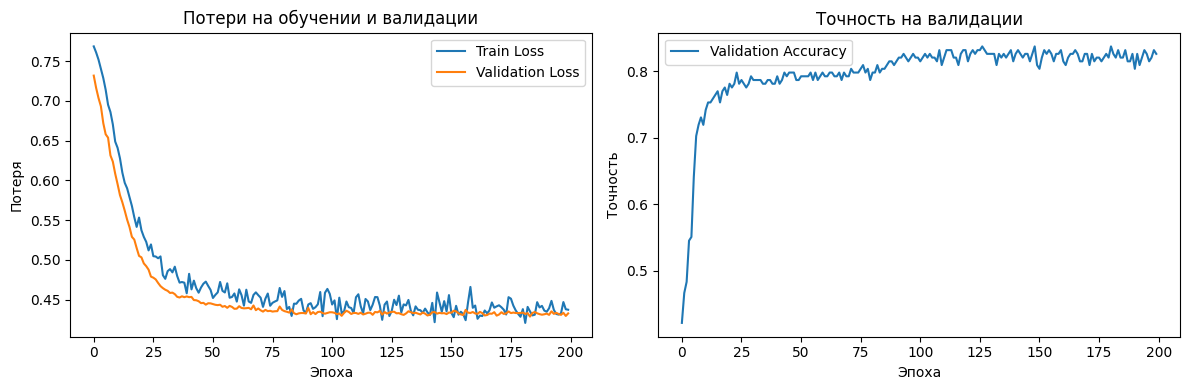

In [56]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Эпоха')
plt.ylabel('Потеря')
plt.legend()
plt.title('Потери на обучении и валидации')

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Эпоха')
plt.ylabel('Точность')
plt.legend()
plt.title('Точность на валидации')

plt.tight_layout()
plt.show()


### 14. СОЗДАНИЕ SUBMISSION ФАЙЛА

In [57]:
model.eval()
all_predictions = []

with torch.no_grad():
    for features_batch in test_loader:
        features_batch = features_batch.to(device)
        outputs_logits = model(features_batch)
        predicted_probs = torch.sigmoid(outputs_logits)
        predicted_classes = (predicted_probs > 0.5).int()
        all_predictions.extend(predicted_classes.cpu().numpy().flatten().tolist())

print(f"Предсказания для {len(all_predictions)} тестовых примеров сгенерированы.")

# Создание submission файла
if 'PassengerId' in df_test_original.columns:
    if len(df_test_original) == len(all_predictions):
        submission_df = pd.DataFrame({
            'PassengerId': df_test_original['PassengerId'],
            'Survived': all_predictions
        })
        
        submission_filename = 'submission_titanic_pytorch.csv'
        submission_df.to_csv(submission_filename, index=False)
        
        print(f"\nSubmission файл '{submission_filename}' успешно создан.")
        print("Первые 5 строк submission файла:")
        print(submission_df.head())
        print(f"\nРаспределение предсказаний:")
        print(f"Выжили: {sum(all_predictions)} ({sum(all_predictions)/len(all_predictions)*100:.1f}%)")
        print(f"Погибли: {len(all_predictions)-sum(all_predictions)} ({(len(all_predictions)-sum(all_predictions))/len(all_predictions)*100:.1f}%)")
    else:
        print(f"\nОшибка: Несовпадение количества предсказаний ({len(all_predictions)}) "
              f"и строк в исходных данных ({len(df_test_original)})")
else:
    print("\nОшибка: Столбец 'PassengerId' не найден в исходных данных")

print(f"\nФинальная точность на валидации: {val_accuracies[-1]:.4f}")
print("Анализ завершен!")

Предсказания для 418 тестовых примеров сгенерированы.

Submission файл 'submission_titanic_pytorch.csv' успешно создан.
Первые 5 строк submission файла:
   PassengerId  Survived
0          892         0
1          893         0
2          894         0
3          895         0
4          896         0

Распределение предсказаний:
Выжили: 59 (14.1%)
Погибли: 359 (85.9%)

Финальная точность на валидации: 0.8258
Анализ завершен!
